In [5]:
!pip install opencv-python


In [6]:
import cv2 
import os 
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
plt.imshow??

Signature:
plt.imshow(
    X: 'ArrayLike | PIL.Image.Image',
    cmap: 'str | Colormap | None' = None,
    norm: 'str | Normalize | None' = None,
    *,
    aspect: "Literal['equal', 'auto'] | float | None" = None,
    interpolation: 'str | None' = None,
    alpha: 'float | ArrayLike | None' = None,
    vmin: 'float | None' = None,
    vmax: 'float | None' = None,
    origin: "Literal['upper', 'lower'] | None" = None,
    extent: 'tuple[float, float, float, float] | None' = None,
    interpolation_stage: "Literal['data', 'rgba'] | None" = None,
    filternorm: 'bool' = True,
    filterrad: 'float' = 4.0,
    resample: 'bool | None' = None,
    url: 'str | None' = None,
    data=None,
    **kwargs,
) -> 'AxesImage'
Docstring:
Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image, set up the colormapping using the parameters
``cmap='gray', vmin

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer,Conv2D,MaxPooling2D,Input,Flatten,Dense

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [10]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [11]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

### Collection of data

In [12]:
import uuid

In [13]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [14]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\17d2614f-2736-11ef-b45f-c0a5e8427ce5.jpg'

In [15]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

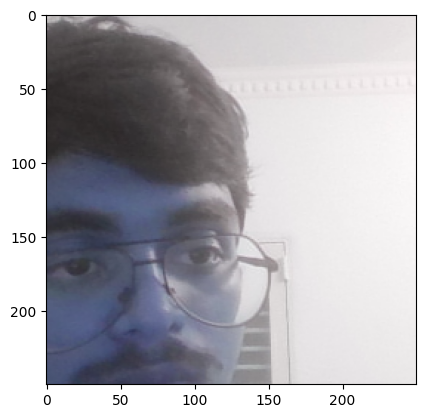

In [16]:
plt.imshow(frame) 

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
dir_test = anchor.as_numpy_iterator()

In [20]:
dir_test.next()

b'data\\anchor\\dc528b36-202d-11ef-86f5-c0a5e8427ce5.jpg'

In [21]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img
    

In [22]:
img = preprocess('data\\anchor\\e5a67f42-202d-11ef-b355-c0a5e8427ce5.jpg')

In [23]:
img.numpy().max()

0.9860294

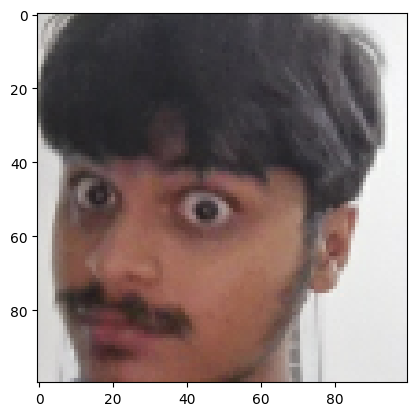

In [24]:
plt.imshow(img)

In [25]:
positives= tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives= tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [26]:
samples = data.as_numpy_iterator()

In [27]:
example = samples.next()

In [28]:
example

(b'data\\anchor\\d688cb40-202d-11ef-ad0a-c0a5e8427ce5.jpg',
 b'data\\positive\\56d47fce-202e-11ef-9388-c0a5e8427ce5.jpg',
 1.0)

In [29]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [30]:
res = preprocess_twin(*example)

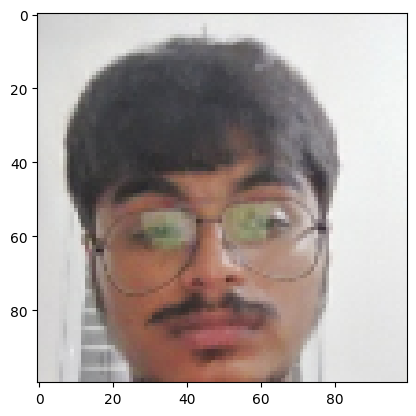

In [31]:
plt.imshow(res[1])

In [32]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [33]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [34]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [35]:
train_samples = train_data.as_numpy_iterator()

In [36]:
train_smaple = train_samples.next()

In [37]:
len(train_smaple[0])

16

In [38]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(16)

In [39]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [42]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [43]:
l1 = L1Dist()

In [44]:
input_image= Input(name='input_img',shape=(100,100,3))
validation_image= Input(name='validation_img',shape=(100,100,3))

In [45]:
inp_embedding= embedding(input_image)
val_embedding= embedding(validation_image)

In [46]:
siamese_layer = L1Dist()

In [47]:
siamese_layer(inp_embedding,val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [48]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:


X = batch_1[:2]



In [57]:
y = batch_1[2]

In [58]:
X

(array([[[[0.8       , 0.8       , 0.8       ],
          [0.81078434, 0.8186275 , 0.8147059 ],
          [0.8188726 , 0.8267157 , 0.81691176],
          ...,
          [0.9512255 , 0.9512255 , 0.9512255 ],
          [0.9558824 , 0.9617647 , 0.9588235 ],
          [0.9517157 , 0.967402  , 0.97132355]],
 
         [[0.7977941 , 0.7977941 , 0.79583335],
          [0.8117647 , 0.8132353 , 0.8105392 ],
          [0.8120098 , 0.81789213, 0.80857843],
          ...,
          [0.9522059 , 0.9522059 , 0.9522059 ],
          [0.95      , 0.9558824 , 0.9529412 ],
          [0.94509804, 0.9607843 , 0.9647059 ]],
 
         [[0.80196077, 0.80196077, 0.7941176 ],
          [0.8134804 , 0.8134804 , 0.80563724],
          [0.8237745 , 0.8237745 , 0.8159314 ],
          ...,
          [0.9588235 , 0.9588235 , 0.9588235 ],
          [0.95661765, 0.9625    , 0.95955884],
          [0.9394608 , 0.9551471 , 0.95906866]],
 
         ...,
 
         [[0.84117645, 0.8372549 , 0.82941175],
          [0.84411

In [59]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [60]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [61]:
EPOCHS = 50

In [62]:
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 22s 401ms/step

 Epoch 2/50
27/27 [==============================] - 10s 371ms/step

 Epoch 3/50
27/27 [==============================] - 10s 370ms/step

 Epoch 4/50
27/27 [==============================] - 10s 369ms/step

 Epoch 5/50
27/27 [==============================] - 9s 353ms/step

 Epoch 6/50
27/27 [==============================] - 9s 343ms/step

 Epoch 7/50
27/27 [==============================] - 9s 337ms/step

 Epoch 8/50
27/27 [==============================] - 9s 328ms/step

 Epoch 9/50
27/27 [==============================] - 8s 317ms/step

 Epoch 10/50
27/27 [==============================] - 8s 312ms/step

 Epoch 11/50
27/27 [==============================] - 8s 310ms/step

 Epoch 12/50
27/27 [==============================] - 8s 307ms/step

 Epoch 13/50
27/27 [==

### Evaluate Model

In [63]:
from tensorflow.keras.metrics import Precision,Recall

In [64]:
test_input, test_val , y_true = test_data.as_numpy_iterator().next()

In [65]:
test_data.as_numpy_iterator().next()

(array([[[[0.7921569 , 0.8       , 0.79607844],
          [0.80196077, 0.80784315, 0.80490196],
          [0.81642157, 0.81642157, 0.81642157],
          ...,
          [0.9110294 , 0.91519606, 0.8926471 ],
          [0.9578431 , 0.9752451 , 0.9583333 ],
          [0.9313725 , 0.95490193, 0.9470588 ]],
 
         [[0.7870098 , 0.7948529 , 0.79093134],
          [0.80269605, 0.80710787, 0.80490196],
          [0.8117647 , 0.8117647 , 0.8117647 ],
          ...,
          [0.7683824 , 0.7622549 , 0.7507353 ],
          [0.9580882 , 0.9580882 , 0.9502451 ],
          [0.9487745 , 0.9580882 , 0.9522059 ]],
 
         [[0.79289216, 0.7948529 , 0.79387254],
          [0.8009804 , 0.8009804 , 0.8009804 ],
          [0.81078434, 0.81078434, 0.81078434],
          ...,
          [0.6870098 , 0.66544116, 0.67034316],
          [0.8620098 , 0.8573529 , 0.8517157 ],
          [0.9529412 , 0.95343137, 0.94534314]],
 
         ...,
 
         [[0.49387255, 0.48995098, 0.51348037],
          [0.41029

In [66]:
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 259ms/step


array([[0.17454174],
       [0.16000935],
       [0.18754786],
       [0.05104009],
       [0.4135405 ],
       [0.5650747 ],
       [0.6621655 ],
       [0.50260544],
       [0.518472  ],
       [0.45183048],
       [0.20845202],
       [0.2061305 ],
       [0.42343888],
       [0.6031716 ],
       [0.7766909 ],
       [0.519611  ]], dtype=float32)

In [67]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]

In [68]:
y_true

array([0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

In [69]:
m = Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

0.75

In [70]:
m = Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

0.85714287

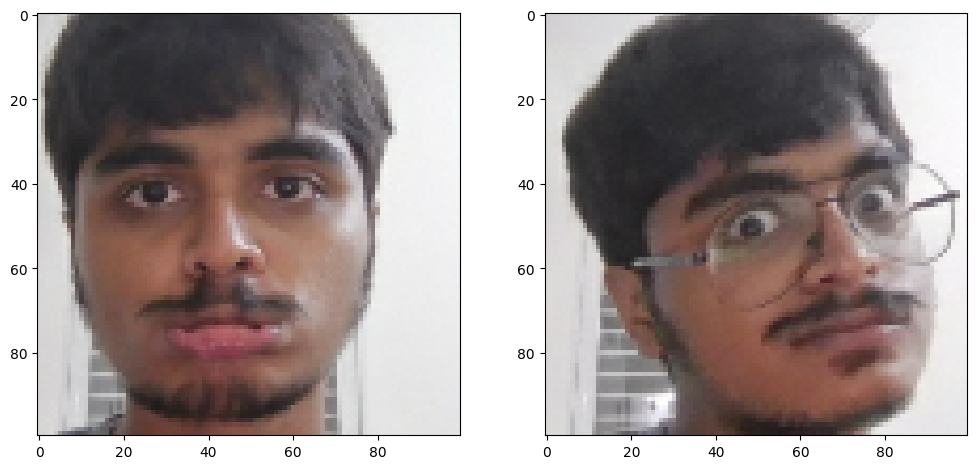

In [71]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()



In [72]:
siamese_model.save('siamesemodel.h5')

In [90]:
model1 = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [74]:
model.predict([test_input,test_val])

1/1 [==============================] - 0s 238ms/step


array([[0.17454174],
       [0.16000935],
       [0.18754786],
       [0.05104009],
       [0.4135405 ],
       [0.5650747 ],
       [0.6621655 ],
       [0.50260544],
       [0.518472  ],
       [0.45183048],
       [0.20845202],
       [0.2061305 ],
       [0.42343888],
       [0.6031716 ],
       [0.7766909 ],
       [0.519611  ]], dtype=float32)

In [91]:
model1.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### Verification

In [77]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [87]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    cv2.imshow('Verification',frame)
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data','input_images','input_image.jpg'),frame)
        results, verified = verify(model,0.5,0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
True


In [ ]:
model.summary()

In [86]:
results > 0.5

TypeError: '>' not supported between instances of 'list' and 'float'